# Customer Segmentation using K-Means clustering algorithm

### Plan
Before we get into the process, I will give you a brief on what kind of steps we will get.
- Download data [here](https://archive.ics.uci.edu/ml/datasets/online+retail)
- Pre-process the data
- Explore the data
- Cluster the data
- Interpret the result



#### Gathering Data

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

!pip install 'openpyxl==3.0.0' 
#! pip install xlrd                        ## in google colab it is not needed

In [5]:
df = pd.read_excel('OnlineRetailDataset.xlsx')
df = df[df['CustomerID'].notna()]
df_fix = df.sample(10000, random_state = 42)

df_fix.shape

(10000, 8)

In [10]:
df_fix.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
47912,540456,48185,DOORMAT FAIRY CAKE,2,2011-01-07,7.95,13534.0,United Kingdom,15.9
342630,566891,23013,GLASS APOTHECARY BOTTLE TONIC,4,2011-09-15,3.95,14894.0,United Kingdom,15.8
288183,C562139,21313,GLASS HEART T-LIGHT HOLDER,-4,2011-08-03,0.85,12921.0,United Kingdom,-3.4
325368,565438,22382,LUNCH BAG SPACEBOY DESIGN,4,2011-09-04,1.65,17229.0,United Kingdom,6.6
331450,566016,21212,PACK OF 72 RETROSPOT CAKE CASES,24,2011-09-08,0.55,15144.0,United Kingdom,13.2


### Data Preprocessing
#### Create RFM Table

In [7]:
# Convert to show date only
from datetime import datetime
df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date

# Create TotalSum colummn
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]

# Create date variable that records recency
import datetime
snapshot_date = max(df_fix.InvoiceDate) + datetime.timedelta(days=1)

# Aggregate data by each customer
customers = df_fix.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [8]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,40,5,133.20
12348.0,249,2,120.88
12349.0,19,2,312.75
12352.0,73,5,80.85
12354.0,233,2,33.30


#### Manage Skewness

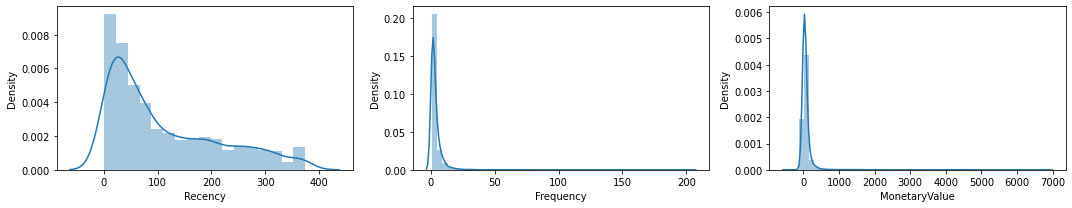

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(customers['Recency'], ax=ax[0])
sns.distplot(customers['Frequency'], ax=ax[1])
sns.distplot(customers['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()

In [20]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(customers[x], ax=ax[0,0])
    sns.distplot(np.log(customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(customers[x].skew().round(2))
    print(np.log(customers[x]).skew().round(2))
    print(np.sqrt(customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customers[x])[0]).skew().round(2))

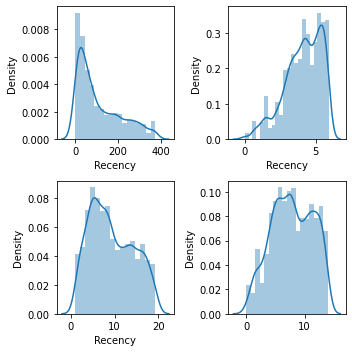

0.93
-0.72
0.32
-0.1


In [45]:
analyze_skewness('Recency')

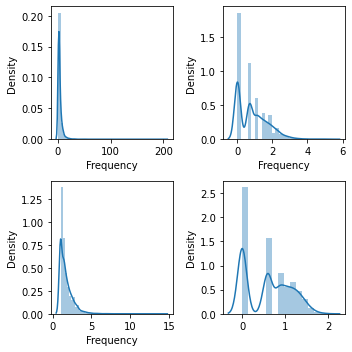

14.77
0.85
3.67
0.16


In [46]:
analyze_skewness('Frequency')

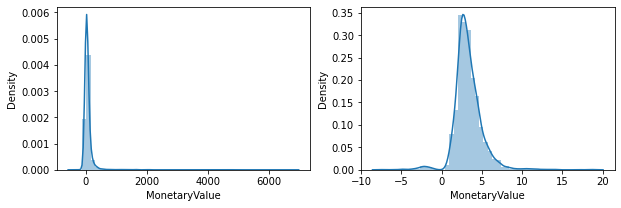

16.63
1.16


In [47]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(customers['MonetaryValue'], ax=ax[0])
sns.distplot(np.cbrt(customers['MonetaryValue']), ax=ax[1])
plt.show()
print(customers['MonetaryValue'].skew().round(2))
print(np.cbrt(customers['MonetaryValue']).skew().round(2))

In [23]:
pd.Series(np.cbrt(customers['MonetaryValue'])).values

array([ 5.10702607,  4.94445183,  6.78785317, ..., -1.66910753,
        4.27320639,  4.0872497 ])

In [24]:
# Set the Numbers
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2685,7.832068,0.591193,3.408514
2686,1.269495,1.435599,5.907565
2687,4.288385,0.591193,-1.669108
2688,1.665555,1.615329,4.273206
2689,6.340700,1.017445,4.087250


#### Centering and Scaling Variables

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[ 0. -0.  0.]
[1. 1. 1.]


In [26]:
pd.DataFrame(customers_normalized).head()

,0,1,2
0,-0.493794,1.012426,1.017503
1,1.232949,-0.017412,0.925115
2,-0.994917,-0.017412,1.972690
3,-0.012582,1.012426,0.572565
4,1.155005,-0.017412,-0.056441


### Modelling
#### Choose k-number

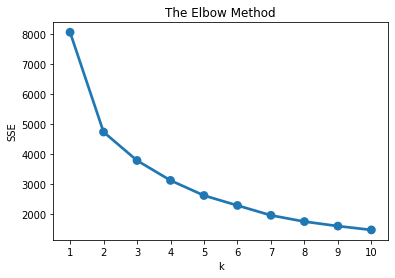

In [27]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [28]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(2690,)

In [29]:
customers.shape

(2690, 3)

### Cluster Analysis

In [30]:
customers["Cluster"] = model.labels_
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,40,5,133.20,0
12348.0,249,2,120.88,2
12349.0,19,2,312.75,0
12352.0,73,5,80.85,0
12354.0,233,2,33.30,2


In [31]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          46.2       7.7         165.8   924
1          47.6       1.6          21.5   811
2         227.3       1.6          28.7   955

### Snake Plots

In [32]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
df_normalized.head()

,Recency,Frequency,MonetaryValue,ID,Cluster
0,-0.493794,1.012426,1.017503,12347.0,0
1,1.232949,-0.017412,0.925115,12348.0,2
2,-0.994917,-0.017412,1.972690,12349.0,0
3,-0.012582,1.012426,0.572565,12352.0,0
4,1.155005,-0.017412,-0.056441,12354.0,2


In [33]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12347.0,0,Recency,-0.493794
1,12348.0,2,Recency,1.232949
2,12349.0,0,Recency,-0.994917
3,12352.0,0,Recency,-0.012582
4,12354.0,2,Recency,1.155005


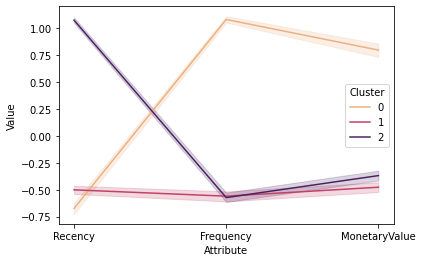

In [49]:
sns.lineplot('Attribute', 'Value',  palette="flare", hue='Cluster', data=df_nor_melt);

loyal customer - has high frequency, high spending <br/>
new customer   - has high recency<br/>
churn customer - all metrics are low<br/>

In [41]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          46.2       7.7         165.8   924
1          47.6       1.6          21.5   811
2         227.3       1.6          28.7   955

In [42]:
cluster_avg = customers.groupby('Cluster').mean()
population_avg = customers.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp

,Cluster,Frequency,MonetaryValue,Recency
Cluster,,,,
0,NaN,1.073687,1.251856,-0.583125
1,NaN,-0.566482,-0.707823,-0.570779
2,NaN,-0.557770,-0.610126,1.048910


### References
Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, 2012, Daqing C., Sai L.S, and Kun G.,  Journal of Database Marketing and Customer Strategy Management.<br>
K. Jarrod Millman and Michael Aivazis. Python for Scientists and Engineers(2011). Computing in Science & Engineering.<br>
https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45